# Analyse BART model for extracting persona summaries from a dialogue

This notebook is meant for analysis and visualization of the results of evaluating the BART model for persona extraction.

The first part of the notebook lists available files in the folder with evaluation results. Use an appropriate filter to load the desired file(s) to analyze.
The analysis uses two types of files as input:
- files ending with '_stats.txt' contain aggregated metrics for an evaluation run as a whole
- files ending with '_evalresults.txt' contain statistics about each sample in the test dataset

The notebook has separate sections for the analysis of the stats files and evalresults files

In [1]:
from dataset.msc_summary import MSC_Summaries
from dataset.msc_summary import plot_heatmaps
import json
import pandas as pd
import numpy as np
import os
import math
from ast import literal_eval
import matplotlib.pyplot as plt

## Load dataset, stats and evalresults

In [2]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_120957_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_120957_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_121242_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_121242_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_121619_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_121619_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_bart_20230628_122031_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/summarize/trained2_base_reweighted_b

In [3]:
# Collect results in dicts
stats_list = []
evalresults_dict = {}
config_list = []

# Load list with ALL trial_names
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

# Trials for SUMMARY GENERATION

selection_fn = lambda s: \
    (s.find('trained_nll05_bart_202308') >= 0) or \
    (s.find('trained_nll05_bart_20230722') >= 0 and \
     s.find('trained_nll05_bart_20230722_00') == -1)  # FINAL RUN with 40 eval runs with for sessions 1-4, with 9 different generation configs

## older runs with summary evaluation
# selection_fn = lambda s: s.find('trained_nll05_bart_20230722_004127') >= 0 # eval run session 4, Flat-Broad beam search
# selection_fn = lambda s: s.find('20230714_20') >= 0         # test with 100 samples from session 3
# selection_fn = lambda s: s.find('20230628_12') >= 0         # trials with trained2_base_reweighted_bart --> version2
# selection_fn = lambda s: s.find('20230628_2') >= 0          # trials with trained_base_reweighted_bart --> version1

trial_names = sorted([f for f in trial_names if selection_fn(f)])

print(f"SELECTED TRIALS ({len(trial_names)}")
print('\n'.join(trial_names))

for trial_name in trial_names:

    # Load the '_stats' file. This contains two dicts:
    # first dict contains the aggregated statistics
    # second dict contains the configuration setting for the run
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    # Load the '_evalresults' file. This contains two dicts:
    # first dict contains the testresults per sample
    # second dict contains the configuration setting for the run
    with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
        data = f.read().replace('\n', '')
        evalresults = json.loads(data.split('}{')[0] + '}')
        evalresults = {literal_eval(k): v for k, v in evalresults.items()}
        for k in evalresults.keys():
            evalresults[k]['trial_name'] = trial_name
        evalresults_dict[trial_name] = evalresults
    
# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(config_list))

SELECTED TRIALS (40
trained_nll05_bart_20230722_025739
trained_nll05_bart_20230722_025741
trained_nll05_bart_20230722_025800
trained_nll05_bart_20230722_025811
trained_nll05_bart_20230722_032346
trained_nll05_bart_20230722_032352
trained_nll05_bart_20230722_032521
trained_nll05_bart_20230722_032600
trained_nll05_bart_20230722_035254
trained_nll05_bart_20230722_035340
trained_nll05_bart_20230722_035345
trained_nll05_bart_20230722_035530
trained_nll05_bart_20230722_040142
trained_nll05_bart_20230722_040319
trained_nll05_bart_20230722_040332
trained_nll05_bart_20230722_040436
trained_nll05_bart_20230722_182310
trained_nll05_bart_20230722_182338
trained_nll05_bart_20230722_182422
trained_nll05_bart_20230722_182441
trained_nll05_bart_20230722_183131
trained_nll05_bart_20230722_183332
trained_nll05_bart_20230722_183335
trained_nll05_bart_20230722_183344
trained_nll05_bart_20230722_185917
trained_nll05_bart_20230722_190043
trained_nll05_bart_20230722_190054
trained_nll05_bart_20230722_190100


In [4]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")

In [5]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")
all_stats_df

,eval_terp_f1,eval_terp_precision,eval_terp_recall,eval_terp_prec_strength,eval_terp_rec_strength,eval_nli_tp_f1,eval_nli_tp_precision,eval_nli_tp_recall,eval_nli_tp_prec_strength,eval_nli_tp_rec_strength,...,load_other,include_persona_other,include_history_other,input_order_other,persona_selector_other,temperature_other,top_p_other,top_k_other,do_sample_other,num_beams_other
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230722_025739,0.426309,0.566365,0.370886,0.400156,0.260180,0.447595,0.565038,0.406096,0.567953,0.412258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_025741,0.461111,0.609534,0.399991,0.421938,0.282396,0.469774,0.585983,0.420723,0.589724,0.429416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_025800,0.475796,0.596048,0.425400,0.422532,0.302712,0.531296,0.629127,0.491939,0.619545,0.487948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_025811,0.661265,0.740941,0.620655,0.554336,0.464741,0.666941,0.737268,0.628356,0.734670,0.628775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032346,0.437594,0.577326,0.380045,0.414477,0.269513,0.445161,0.567569,0.401267,0.569448,0.406723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032352,0.465943,0.618370,0.402545,0.431571,0.285756,0.467002,0.587147,0.416049,0.591076,0.423782,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032521,0.485778,0.616225,0.430024,0.436684,0.308152,0.526588,0.629372,0.483062,0.617792,0.478061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032600,0.670053,0.745385,0.630729,0.560065,0.472712,0.664991,0.735365,0.626063,0.733190,0.625804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_035254,0.477621,0.557674,0.449683,0.395282,0.321447,0.502164,0.554584,0.495837,0.548193,0.490125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
all_config_df

,configfile,seed,checkpoint_dir,output_dir,log_interval,loglevel,logdir,load,save,device,...,load_other,include_persona_other,include_history_other,input_order_other,persona_selector_other,temperature_other,top_p_other,top_k_other,do_sample_other,num_beams_other
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230722_025739,None,42,checkpoints/,/scratch-local/frankv.3122162/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_025741,None,42,checkpoints/,/scratch-local/frankv.3122161/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_025800,None,42,checkpoints/,/scratch-local/frankv.3122160/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_025811,None,42,checkpoints/,/scratch-local/frankv.3122159/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032346,None,42,checkpoints/,/scratch-local/frankv.3122200/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032352,None,42,checkpoints/,/scratch-local/frankv.3122199/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032521,None,42,checkpoints/,/scratch-local/frankv.3122198/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_032600,None,42,checkpoints/,/scratch-local/frankv.3122197/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trained_nll05_bart_20230722_035254,None,42,checkpoints/,/scratch-local/frankv.3122369/output/,10,DEBUG,None,trained_nll05_bart,,cuda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Convert eval_results to DataFrame and combine with config

eval_results_df = pd.concat([
    pd.DataFrame.from_records(list(evalresults_dict[trial_name].values()))
    for trial_name in evalresults_dict.keys()
])
eval_results_df = eval_results_df.join(all_config_df, on='trial_name')
eval_results_df.head()

,convai_id,pred_sentences,target_sentences,num_combinations,terp,nli,nli_tp,nli_pt,nli_avg,numwords_factor,...,load_other,include_persona_other,include_history_other,input_order_other,persona_selector_other,temperature_other,top_p_other,top_k_other,do_sample_other,num_beams_other
0,test_0,"[i am looking for a new gym, i am looking forw...","[i am joining a gym near me, i run, i am looki...",42,"{'scores': [[0.7040180563926697, 1.0, 1.0, 1.0...",{},"{'scores': [[0.25650373101234436, 0.0023397046...","{'scores': [[0.0023414120078086853, 0.00058194...","{'scores': [[0.12942257523536682, 0.0014608231...",0.676923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test_2,"[i have a few animals, i have chickens, i have...","[i have chickens, i grow crops, i have a farm,...",24,"{'scores': [[0.6914177536964417, 0.0, 0.086284...",{},"{'scores': [[0.7078720331192017, 0.99569809436...","{'scores': [[0.0030593047849833965, 0.99569809...","{'scores': [[0.35546568036079407, 0.9956980943...",0.580882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,test_6,"[i have a grandmother, i have an orange tree, ...","[i have a grandmother, i have a neighbor, i ha...",42,"{'scores': [[0.0, 0.8429871201515198, 0.389136...",{},"{'scores': [[0.9942650198936462, 0.00367943523...","{'scores': [[0.9942650198936462, 0.01308989338...","{'scores': [[0.9942650198936462, 0.00838466454...",0.696970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,test_7,"[i have back pains, i am thinking of going to ...","[i have a neighbor, i am interested in buying ...",21,"{'scores': [[0.7782739400863647, 1.0, 0.712702...",{},"{'scores': [[0.015891926363110542, 0.002274162...","{'scores': [[0.005807328503578901, 0.012768442...","{'scores': [[0.010849627666175365, 0.007521302...",0.610526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,test_8,"[i have a family, i have kids, i have a husband]","[i haven't watched any new movies lately, my f...",15,"{'scores': [[1.0, 1.0, 1.0], [0.97829341888427...",{},"{'scores': [[0.0053237187676131725, 0.00435279...","{'scores': [[0.0011346820974722505, 0.00090532...","{'scores': [[0.0032292003743350506, 0.00262906...",0.234043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
eval_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20040 entries, 0 to 500
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   convai_id               20040 non-null  object 
 1   pred_sentences          20040 non-null  object 
 2   target_sentences        20040 non-null  object 
 3   num_combinations        20040 non-null  int64  
 4   terp                    20040 non-null  object 
 5   nli                     20040 non-null  object 
 6   nli_tp                  20040 non-null  object 
 7   nli_pt                  20040 non-null  object 
 8   nli_avg                 20040 non-null  object 
 9   numwords_factor         20040 non-null  float64
 10  numfacts_factor         20040 non-null  float64
 11  rougeL                  20040 non-null  object 
 12  trial_name              20040 non-null  object 
 13  configfile              0 non-null      object 
 14  seed                    20040 non-null  

### Add additional columns to facilitate analysis

In [9]:
# Helper functions

def format_gen_config(settings):
    # settings contains: do_sample, num_beams, temp, top_p, top_k
    if settings[0] == False:
        return "Greedy"
    else:
        if settings[1] == 1 and settings[2] == 1.0 and settings[3] == 1.0 and settings[4] == 0:
            return "Unbiased sampling"
        elif settings[1] == 5 and settings[2] == 1.0 and settings[3] == 0.9 and settings[4] == 10:
            return "Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 10:
            return "Flat-Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 50:
            return "Flat-Broad beam"
        else:
            return f"b={int(settings[1])}, t={settings[2]:.1f}, top_p={settings[3]:.1f}, top_k={int(settings[4])}"

In [10]:
# Define the groupby columns
from pandas.api.types import CategoricalDtype

decoder_options = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)

In [11]:
all_stats_df['gen_config'] = all_stats_df[decoder_options].apply(format_gen_config, axis=1).astype(gen_config_cat)
eval_results_df['gen_config'] = eval_results_df[decoder_options].apply(format_gen_config, axis=1).astype(gen_config_cat)

## Analysis of the aggregated stats

In [12]:
all_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, trained_nll05_bart_20230722_025739 to trained_nll05_bart_20230807_004034
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   eval_terp_f1                40 non-null     float64 
 1   eval_terp_precision         40 non-null     float64 
 2   eval_terp_recall            40 non-null     float64 
 3   eval_terp_prec_strength     40 non-null     float64 
 4   eval_terp_rec_strength      40 non-null     float64 
 5   eval_nli_tp_f1              40 non-null     float64 
 6   eval_nli_tp_precision       40 non-null     float64 
 7   eval_nli_tp_recall          40 non-null     float64 
 8   eval_nli_tp_prec_strength   40 non-null     float64 
 9   eval_nli_tp_rec_strength    40 non-null     float64 
 10  eval_nli_pt_f1              40 non-null     float64 
 11  eval_nli_pt_precision       40 non-null     float64 
 12  eval_nli_pt_recall  

In [13]:
# Define the list of metrics and submetrics

# Change columns names so that 'prec_strength' can be identified as submetric
all_stats_df.columns = [c.replace('_strength', 'strength') for c in all_stats_df.columns]

submetrics = {}
for c in all_stats_df.columns:
    if c[:5] == 'eval_':
        c_split = c.split('_')
        metric = '_'.join(c_split[1:-1])
        submetric = c_split[-1]
        if not metric in submetrics.keys():
            submetrics[metric] = [submetric]
        else:
            submetrics[metric].append(submetric)
metrics = list(submetrics.keys())
metric_keys = [c for c in all_stats_df.columns if c[:5] == 'eval_']

print(metrics)
print(submetrics)
print(metric_keys)


['terp', 'nli_tp', 'nli_pt', 'nli_avg', 'numwords', 'numfacts', 'rougeL']
{'terp': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'nli_tp': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'nli_pt': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'nli_avg': ['f1', 'precision', 'recall', 'precstrength', 'recstrength'], 'numwords': ['factor'], 'numfacts': ['factor'], 'rougeL': ['fmeasure', 'precision', 'recall']}
['eval_terp_f1', 'eval_terp_precision', 'eval_terp_recall', 'eval_terp_precstrength', 'eval_terp_recstrength', 'eval_nli_tp_f1', 'eval_nli_tp_precision', 'eval_nli_tp_recall', 'eval_nli_tp_precstrength', 'eval_nli_tp_recstrength', 'eval_nli_pt_f1', 'eval_nli_pt_precision', 'eval_nli_pt_recall', 'eval_nli_pt_precstrength', 'eval_nli_pt_recstrength', 'eval_nli_avg_f1', 'eval_nli_avg_precision', 'eval_nli_avg_recall', 'eval_nli_avg_precstrength', 'eval_nli_avg_recstrength', 'eval_numwords_factor', 'eval_numfacts_factor', 'eval_rougeL_fmeasu

### Aggregated stats for summary evaluation, by gen_config

In [14]:
# result_df = all_stats_df.groupby(by=decoder_options + ['session'])[metric_keys].agg(['mean', 'std'])
# result_df = all_stats_df.groupby(by=['session'] + decoder_options)[metric_keys].agg(['mean', 'std'])
result_df = all_stats_df.groupby(by=['session', 'gen_config'])[metric_keys].agg(['mean'])


newcolumns = pd.MultiIndex.from_tuples([(m, s, a) for m in metrics for s in submetrics[m] for a in ['mean']])
result_df.columns = newcolumns
result_df.columns = result_df.columns.droplevel(2)
result_df

terp                                   \
                                 f1 precision    recall precstrength   
session gen_config                                                     
1       Greedy             0.661265  0.740941  0.620655     0.554336   
        Unbiased sampling  0.567433  0.616555  0.553908     0.440604   
        Narrow beam        0.670053  0.745385  0.630729     0.560065   
        Flat-Narrow beam   0.677868  0.736211  0.650833     0.554562   
        Flat-Broad beam    0.676381  0.723690  0.657587     0.538892   
2       Greedy             0.475796  0.596048  0.425400     0.422532   
        Unbiased sampling  0.364123  0.427877  0.344933     0.286836   
        Narrow beam        0.485778  0.616225  0.430024     0.436684   
        Flat-Narrow beam   0.490036  0.592189  0.448830     0.417314   
        Flat-Broad beam    0.477621  0.557674  0.449683     0.395282   
3       Greedy             0.461111  0.609534  0.399991     0.421938   
        Unbiased sampling  0.355869  0.437169  0.331281     0.284646   
        Narrow beam        0.465943  0.618370  0.402545     0.431571   
        Flat-Narrow beam   0.470923  0.591151  0.421618     0.410634   
        Flat-Broad beam    0.473452  0.573843  0.434452     0.394121   
4       Greedy             0.426309  0.566365  0.370886     0.400156   
        Unbiased sampling  0.313035  0.391099  0.293120     0.260471   
        Narrow beam        0.437594  0.577326  0.380045     0.414477   
        Flat-Narrow beam   0.453601  0.563829  0.409681     0.392506   
        Flat-Broad beam    0.454596  0.554517  0.417072     0.379455   

                                         nli_tp                      \
                          recstrength        f1 precision    recall   
session gen_config                                                    
1       Greedy               0.464741  0.666941  0.737268  0.628356   
        Unbiased sampling    0.395175  0.508805  0.551078  0.500545   
        Narrow beam          0.472712  0.664991  0.735365  0.626063   
        Flat-Narrow beam     0.491650  0.651928  0.701642  0.628648   
        Flat-Broad beam      0.491131  0.647949  0.686834  0.633404   
2       Greedy               0.302712  0.531296  0.629127  0.491939   
        Unbiased sampling    0.237431  0.351922  0.389197  0.356148   
        Narrow beam          0.308152  0.526588  0.629372  0.483062   
        Flat-Narrow beam     0.320485  0.506573  0.581152  0.480917   
        Flat-Broad beam      0.321447  0.502164  0.554584  0.495837   
3       Greedy               0.282396  0.469774  0.585983  0.420723   
        Unbiased sampling    0.220527  0.301438  0.352651  0.296550   
        Narrow beam          0.285756  0.467002  0.587147  0.416049   
        Flat-Narrow beam     0.298091  0.446006  0.537615  0.412416   
        Flat-Broad beam      0.301703  0.444011  0.514358  0.424867   
4       Greedy               0.260180  0.447595  0.565038  0.406096   
        Unbiased sampling    0.198229  0.270345  0.321886  0.268543   
        Narrow beam          0.269513  0.445161  0.567569  0.401267   
        Flat-Narrow beam     0.283045  0.423556  0.502316  0.400913   
        Flat-Broad beam      0.287364  0.422709  0.482131  0.410937   

                                                    ...   nli_avg            \
                          precstrength recstrength  ...        f1 precision   
session gen_config                                  ...                       
1       Greedy                0.734670    0.628775  ...  0.552670  0.623774   
        Unbiased sampling     0.554433    0.505224  ...  0.423632  0.464997   
        Narrow beam           0.733190    0.625804  ...  0.560731  0.632760   
        Flat-Narrow beam      0.700682    0.627220  ...  0.566074  0.617087   
        Flat-Broad beam       0.685515    0.633781  ...  0.560032  0.601994   
2       Greedy                0.619545    0.487948  ...  0.345645  0.436207   
        Unbiased sampling    

In [15]:
### ***THESIS*** Table 4.6

table_cols = pd.MultiIndex.from_product([['terp', 'nli_avg'], ['f1', 'precision', 'recall']])

table_df = result_df[table_cols]
table_df = table_df.stack().stack()
table_df = table_df.unstack(0)
# table_df = table_df.unstack(2)
table_df = table_df.unstack(1)
table_df = table_df.reorder_levels([1,0], axis=0)
table_df = table_df.reindex([(m, c) for m in ['terp', 'nli_avg'] for c in list(gen_config_cat.categories) ], axis=0)
table_df = table_df.droplevel(0, axis=0)
# table_df = table_df.reindex([(s, m) for s in [1, 2, 3, 4] for m in ['terp', 'nli_avg']], axis=1)
table_df

session                   1                             2                      \
                         f1 precision    recall        f1 precision    recall   
gen_config                                                                      
Greedy             0.661265  0.740941  0.620655  0.475796  0.596048  0.425400   
Unbiased sampling  0.567433  0.616555  0.553908  0.364123  0.427877  0.344933   
Narrow beam        0.670053  0.745385  0.630729  0.485778  0.616225  0.430024   
Flat-Narrow beam   0.677868  0.736211  0.650833  0.490036  0.592189  0.448830   
Flat-Broad beam    0.676381  0.723690  0.657587  0.477621  0.557674  0.449683   
Greedy             0.552670  0.623774  0.512692  0.345645  0.436207  0.309555   
Unbiased sampling  0.423632  0.464997  0.409780  0.247988  0.284899  0.241578   
Narrow beam        0.560731  0.632760  0.520060  0.351081  0.448044  0.310389   
Flat-Narrow beam   0.566074  0.617087  0.540609  0.349212  0.417380  0.323184   
Flat-Broad beam    0.560032  0.601994  0.542002  0.345215  0.397298  0.332294   

session                   3                             4                      
                         f1 precision    recall        f1 precision    recall  
gen_config                                                                     
Greedy             0.461111  0.609534  0.399991  0.426309  0.566365  0.370886  
Unbiased sampling  0.355869  0.437169  0.331281  0.313035  0.391099  0.293120  
Narrow beam        0.465943  0.618370  0.402545  0.437594  0.577326  0.380045  
Flat-Narrow beam   0.470923  0.591151  0.421618  0.453601  0.563829  0.409681  
Flat-Broad beam    0.473452  0.573843  0.434452  0.454596  0.554517  0.417072  
Greedy             0.324142  0.437484  0.276416  0.297471  0.404061  0.255300  
Unbiased sampling  0.217490  0.272713  0.202968  0.188598  0.232411  0.178152  
Narrow beam        0.331235  0.450788  0.281802  0.301302  0.408908  0.258568  
Flat-Narrow beam   0.327863  0.416656  0.290516  0.303567  0.381323  0.273135  
Flat-Broad beam    0.328095  0.399155  0.301763  0.301157  0.364634  0.278656

In [16]:
### ***THESIS*** Table 4.6 (conversion to latex)

s = table_df.style.format(precision=2)
print(s.to_latex(hrules=True).replace('f1', 'F1').replace('precision', 'P').replace('recall', 'R').replace('terp', 'TERp').replace('nli_avg', 'NLI').replace('gen_config', ''))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
session & \multicolumn{3}{r}{1} & \multicolumn{3}{r}{2} & \multicolumn{3}{r}{3} & \multicolumn{3}{r}{4} \\
 & F1 & P & R & F1 & P & R & F1 & P & R & F1 & P & R \\
 &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Greedy & 0.66 & 0.74 & 0.62 & 0.48 & 0.60 & 0.43 & 0.46 & 0.61 & 0.40 & 0.43 & 0.57 & 0.37 \\
Unbiased sampling & 0.57 & 0.62 & 0.55 & 0.36 & 0.43 & 0.34 & 0.36 & 0.44 & 0.33 & 0.31 & 0.39 & 0.29 \\
Narrow beam & 0.67 & 0.75 & 0.63 & 0.49 & 0.62 & 0.43 & 0.47 & 0.62 & 0.40 & 0.44 & 0.58 & 0.38 \\
Flat-Narrow beam & 0.68 & 0.74 & 0.65 & 0.49 & 0.59 & 0.45 & 0.47 & 0.59 & 0.42 & 0.45 & 0.56 & 0.41 \\
Flat-Broad beam & 0.68 & 0.72 & 0.66 & 0.48 & 0.56 & 0.45 & 0.47 & 0.57 & 0.43 & 0.45 & 0.55 & 0.42 \\
Greedy & 0.55 & 0.62 & 0.51 & 0.35 & 0.44 & 0.31 & 0.32 & 0.44 & 0.28 & 0.30 & 0.40 & 0.26 \\
Unbiased sampling & 0.42 & 0.46 & 0.41 & 0.25 & 0.28 & 0.24 & 0.22 & 0.27 & 0.20 & 0.19 & 0.23 & 0.18 \\
Narrow beam & 0.56 & 0.63 & 0.52 & 0.35 & 0.

In [17]:
# Show metric for all eval runs, grouped by generation config settings

# result_df = all_stats_df.groupby(by=decoder_options + ['session'])[metric_keys].agg(['mean', 'std'])
# result_df = all_stats_df.groupby(by=['session'] + decoder_options)[metric_keys].agg(['mean', 'std'])
result_df = all_stats_df.groupby(by=decoder_options)[metric_keys].agg(['mean', 'std'])


newcolumns = pd.MultiIndex.from_tuples([(m, s, a) for m in metrics for s in submetrics[m] for a in ['mean', 'std']])
result_df.columns = newcolumns

result_df

terp                      \
                                                   f1           precision   
                                                 mean       std      mean   
do_sample num_beams temperature top_p top_k                                 
False     1         1.0         1.0   50     0.506120  0.105491  0.628222   
True      1         1.0         0.9   10     0.459288  0.107793  0.551045   
                                1.0   0      0.400115  0.113771  0.468175   
                                      50     0.411877  0.111853  0.486326   
                    1.5         0.9   10     0.384343  0.102417  0.450343   
                                      50     0.319125  0.106845  0.368793   
          5         1.0         0.9   10     0.514842  0.105346  0.639326   
                                      50     0.517911  0.103386  0.643668   
                    1.5         0.9   10     0.523107  0.104242  0.620845   
                                      50     0.520512  0.104394  0.602431   

                                                                           \
                                                         recall             
                                                  std      mean       std   
do_sample num_beams temperature top_p top_k                                 
False     1         1.0         1.0   50     0.077279  0.454233  0.113161   
True      1         1.0         0.9   10     0.087883  0.428033  0.111366   
                                1.0   0      0.100900  0.380810  0.117463   
                                      50     0.100266  0.390576  0.115192   
                    1.5         0.9   10     0.100027  0.372173  0.099282   
                                      50     0.106403  0.311950  0.105135   
          5         1.0         0.9   10     0.073179  0.460836  0.115091   
                                      50     0.070444  0.463251  0.113620   
                    1.5         0.9   10     0.078023  0.482740  0.113253   
                                      50     0.081281  0.489699  0.112716   

                                                                    \
                                            precstrength             
                                                    mean       std   
do_sample num_beams temperature top_p top_k                          
False     1         1.0         1.0   50        0.449741  0.070503   
True      1         1.0         0.9   10        0.380624  0.076689   
                                1.0   0         0.318139  0.082513   
                                      50        0.332354  0.079741   
                    1.5         0.9   10        0.299179  0.077817   
                                      50        0.243062  0.074703   
          5         1.0         0.9   10        0.460699  0.066921   
                                      50        0.463260  0.066884   
                    1.5         0.9   10        0.443754  0.074612   
                                      50        0.426937  0.074983   

                                                                   ...  \
                                            recstrength            ...   
                                                   mean       std  ...   
do_sample num_beams temperature top_p top_k                        ...   
False     1         1.0         1.0   50       0.327507  0.093123  ...   
True      1         1.0         0.9   10       0.299206  0.088792  ...   
                                1.0   0        0.262841  0.089672  ...   
                                      50       0.269600  0.087172  ...   
                    1.5         0.9   10       0.249129  0.078392  ...   
                                      50       0.206506  0.074764  ...   
          5         1.0         0.9   10       0.334033  0.093800  ...   
                                      50       0.335820  0.093302  ...   
                    1.

### Plot of all metrics, by gen_config, and/or session

In [18]:
# Define 'fresh' results_df

result_df = all_stats_df.groupby(by=decoder_options)[metric_keys].agg(['mean', 'std'])
newcolumns = pd.MultiIndex.from_tuples([(m, s, a) for m in metrics for s in submetrics[m] for a in ['mean', 'std']])
result_df.columns = newcolumns

result_df

terp                      \
                                                   f1           precision   
                                                 mean       std      mean   
do_sample num_beams temperature top_p top_k                                 
False     1         1.0         1.0   50     0.506120  0.105491  0.628222   
True      1         1.0         0.9   10     0.459288  0.107793  0.551045   
                                1.0   0      0.400115  0.113771  0.468175   
                                      50     0.411877  0.111853  0.486326   
                    1.5         0.9   10     0.384343  0.102417  0.450343   
                                      50     0.319125  0.106845  0.368793   
          5         1.0         0.9   10     0.514842  0.105346  0.639326   
                                      50     0.517911  0.103386  0.643668   
                    1.5         0.9   10     0.523107  0.104242  0.620845   
                                      50     0.520512  0.104394  0.602431   

                                                                           \
                                                         recall             
                                                  std      mean       std   
do_sample num_beams temperature top_p top_k                                 
False     1         1.0         1.0   50     0.077279  0.454233  0.113161   
True      1         1.0         0.9   10     0.087883  0.428033  0.111366   
                                1.0   0      0.100900  0.380810  0.117463   
                                      50     0.100266  0.390576  0.115192   
                    1.5         0.9   10     0.100027  0.372173  0.099282   
                                      50     0.106403  0.311950  0.105135   
          5         1.0         0.9   10     0.073179  0.460836  0.115091   
                                      50     0.070444  0.463251  0.113620   
                    1.5         0.9   10     0.078023  0.482740  0.113253   
                                      50     0.081281  0.489699  0.112716   

                                                                    \
                                            precstrength             
                                                    mean       std   
do_sample num_beams temperature top_p top_k                          
False     1         1.0         1.0   50        0.449741  0.070503   
True      1         1.0         0.9   10        0.380624  0.076689   
                                1.0   0         0.318139  0.082513   
                                      50        0.332354  0.079741   
                    1.5         0.9   10        0.299179  0.077817   
                                      50        0.243062  0.074703   
          5         1.0         0.9   10        0.460699  0.066921   
                                      50        0.463260  0.066884   
                    1.5         0.9   10        0.443754  0.074612   
                                      50        0.426937  0.074983   

                                                                   ...  \
                                            recstrength            ...   
                                                   mean       std  ...   
do_sample num_beams temperature top_p top_k                        ...   
False     1         1.0         1.0   50       0.327507  0.093123  ...   
True      1         1.0         0.9   10       0.299206  0.088792  ...   
                                1.0   0        0.262841  0.089672  ...   
                                      50       0.269600  0.087172  ...   
                    1.5         0.9   10       0.249129  0.078392  ...   
                                      50       0.206506  0.074764  ...   
          5         1.0         0.9   10       0.334033  0.093800  ...   
                                      50       0.335820  0.093302  ...   
                    1.

In [19]:
def plot_sessioneval_byconfig(df, eval_metrics):

    # Define figure format
    fig, ax_grid = plt.subplots(nrows=4, ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 8), sharey=True)

    for config in range(4):

        result_df = df.iloc[config*4 : (config+1)*4]
        axs = ax_grid.flatten()[config * len(eval_metrics): (config+1) * len(eval_metrics)]
        
        # Loopt over metrics to plot bar charts
        for (metric, submetric), ax in zip(eval_metrics, axs):
            
            # Plot bar chart
            ax_bar = ax.barh(y=list(range(len(result_df))), width=result_df[metric][submetric]['mean'][::-1])

            # Print value in tha max bar, and color the bars
            max_value = result_df[metric][submetric]['mean'].max()
            x_min = 0 #result_df[metric][submetric]['mean'].min() * 0.5
            xticks = ax.get_xticks()
            digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
            for i, v in enumerate(result_df[metric][submetric]['mean'][::-1]):
                if v == max_value:
                    ax_bar[i].set_color('g')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
                elif v > 0.95 * max_value:
                    ax_bar[i].set_color('y')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
            
            # Add title, other formatting
            ax.set_title(f"{metric}\n{submetric}")
            ax.set_xlim(x_min, min(1, max_value * 1.25))

        # Remove labels n left side (to make room for the table)
        axs[0].set_yticks([])
        axs[0].set_yticklabels([])

        # Plot a table with the parameters of the generation config
        # NOTE: Table items are in reversed order compared to bars !!
        ax_table = axs[0].table(
            cellText=result_df.index.values,
            colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in [str(session)] + decoder_options] if session == 1 else None,
            cellLoc='center',
            bbox=[-3, 0, 2.8, 1.25 if session == 1 else 1.0],
        )
        ax_table.auto_set_font_size(False)
        ax_table.set_fontsize(10)

    # Main title for the figure
    # fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
    fig.tight_layout()


In [20]:
def plot_configeval_bysession(df, eval_metrics):

    # Define figure format
    fig, ax_grid = plt.subplots(nrows=4, ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 8), sharey=True)

    for session in [1, 2, 3, 4]:

        result_df = df.loc[session]
        axs = ax_grid.flatten()[(session-1) * len(eval_metrics): session * len(eval_metrics)]
        
        # Loopt over metrics to plot bar charts
        for (metric, submetric), ax in zip(eval_metrics, axs):
            
            # Plot bar chart
            ax_bar = ax.barh(y=list(range(len(result_df))), width=result_df[metric][submetric]['mean'][::-1])

            # Print value in tha max bar, and color the bars
            max_value = result_df[metric][submetric]['mean'].max()
            x_min = 0 #result_df[metric][submetric]['mean'].min() * 0.5
            xticks = ax.get_xticks()
            digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
            for i, v in enumerate(result_df[metric][submetric]['mean'][::-1]):
                if v == max_value:
                    ax_bar[i].set_color('g')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
                elif v > 0.95 * max_value:
                    ax_bar[i].set_color('y')
                    ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
            
            # Add title, other formatting
            ax.set_title(f"{metric}\n{submetric}")
            ax.set_xlim(x_min, min(1, max_value * 1.25))

        # Remove labels n left side (to make room for the table)
        axs[0].set_yticks([])
        axs[0].set_yticklabels([])

        # Plot a table with the parameters of the generation config
        # NOTE: Table items are in reversed order compared to bars !!
        ax_table = axs[0].table(
            cellText=result_df.index.values,
            colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in [str(session)] + decoder_options] if session == 1 else None,
            cellLoc='center',
            bbox=[-3, 0, 2.8, 1.25 if session == 1 else 1.0],
        )
        ax_table.auto_set_font_size(False)
        ax_table.set_fontsize(10)

    # Main title for the figure
    # fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
    fig.tight_layout()


In [21]:
def plot_configeval(result_df, eval_metrics):

    # Define figure format
    fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), len(result_df.index)), sharey=True)

    # Loopt over metrics to plot bar charts
    for (metric, submetric), ax in zip(eval_metrics, axs):
        
        # Plot bar chart
        # print(result_df[metric][submetric])
        ax_bar = ax.barh(y=list(range(len(result_df))), width=result_df[metric][submetric]['mean'][::-1], xerr=result_df[metric][submetric]['std'])

        # Print value in tha max bar, and color the bars
        max_value = result_df[metric][submetric]['mean'].max()
        x_min = 0 #result_df[metric][submetric]['mean'].min() * 0.5
        xticks = ax.get_xticks()
        digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
        for i, v in enumerate(result_df[metric][submetric]['mean'][::-1]):
            if v == max_value:
                ax_bar[i].set_color('g')
                # ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
            elif v > 0.95 * max_value:
                ax_bar[i].set_color('y')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        
        # Add title, other formatting
        ax.set_title(f"{metric}\n{submetric}")
        ax.set_xlim(x_min, min(1.25, max_value * 1.25))

    # Remove labels n left side (to make room for the table)
    axs[0].set_yticks([])
    axs[0].set_yticklabels([])

    # Plot a table with the parameters of the generation config
    # NOTE: Table items are in reversed order compared to bars !!
    ax_table = axs[0].table(
        cellText=result_df.index.values,
        colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
        cellLoc='center',
        bbox=[-3, 0, 2.8, 1 + 1/len(result_df.index)],
    )
    ax_table.auto_set_font_size(False)
    ax_table.set_fontsize(10)

    # Main title for the figure
    # fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
    # fig.tight_layout()


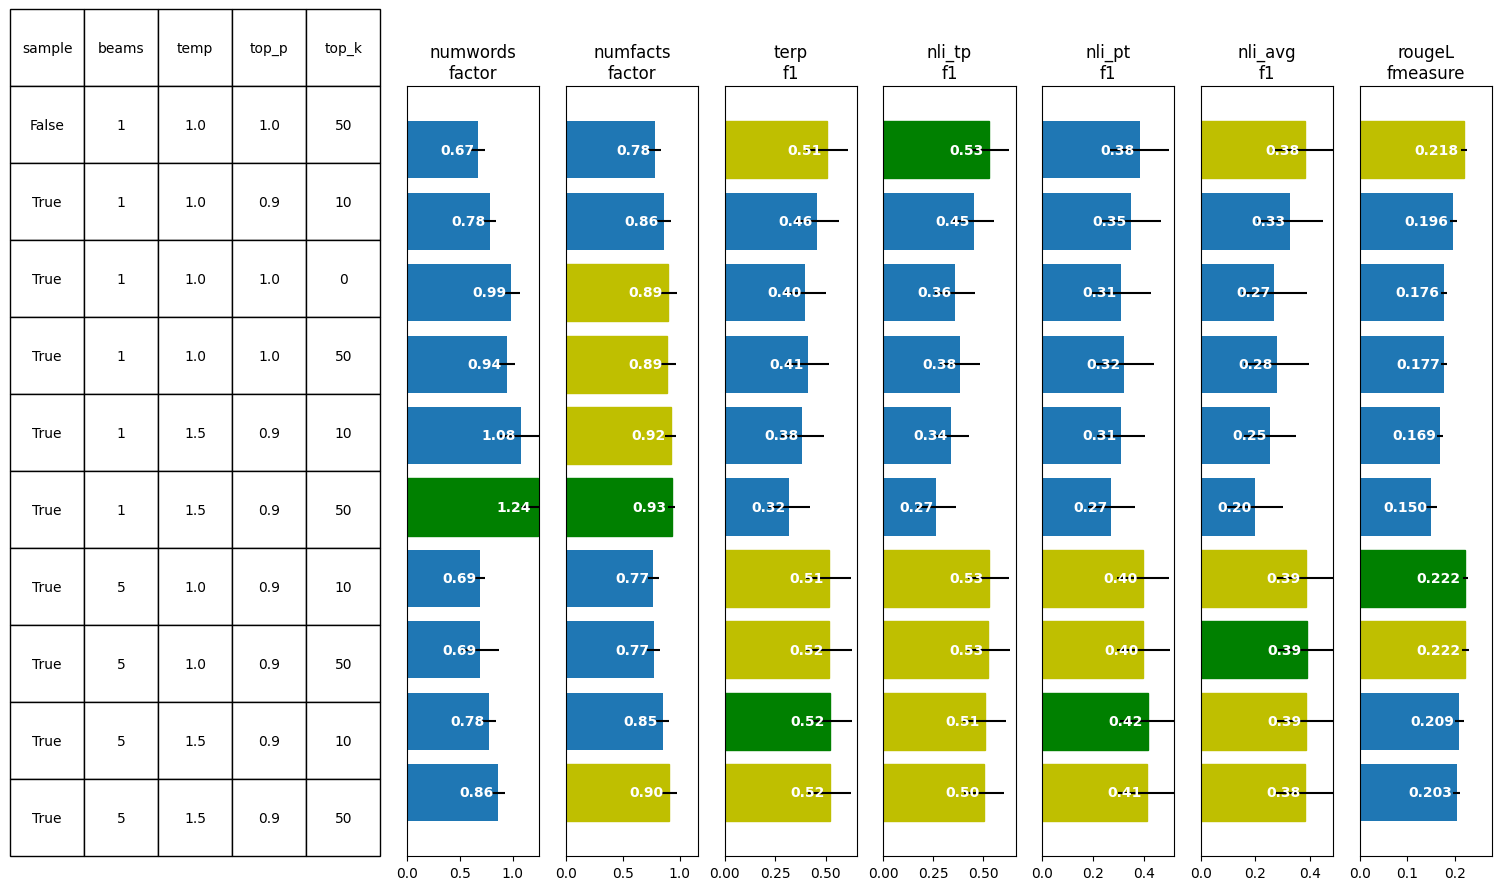

In [22]:
# Define metrics to show
eval_metrics = [('numwords', 'factor'), ('numfacts', 'factor')] + [(m, s) for m in metrics for s in submetrics[m] if (s=='fmeasure' or s=='f1')]
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

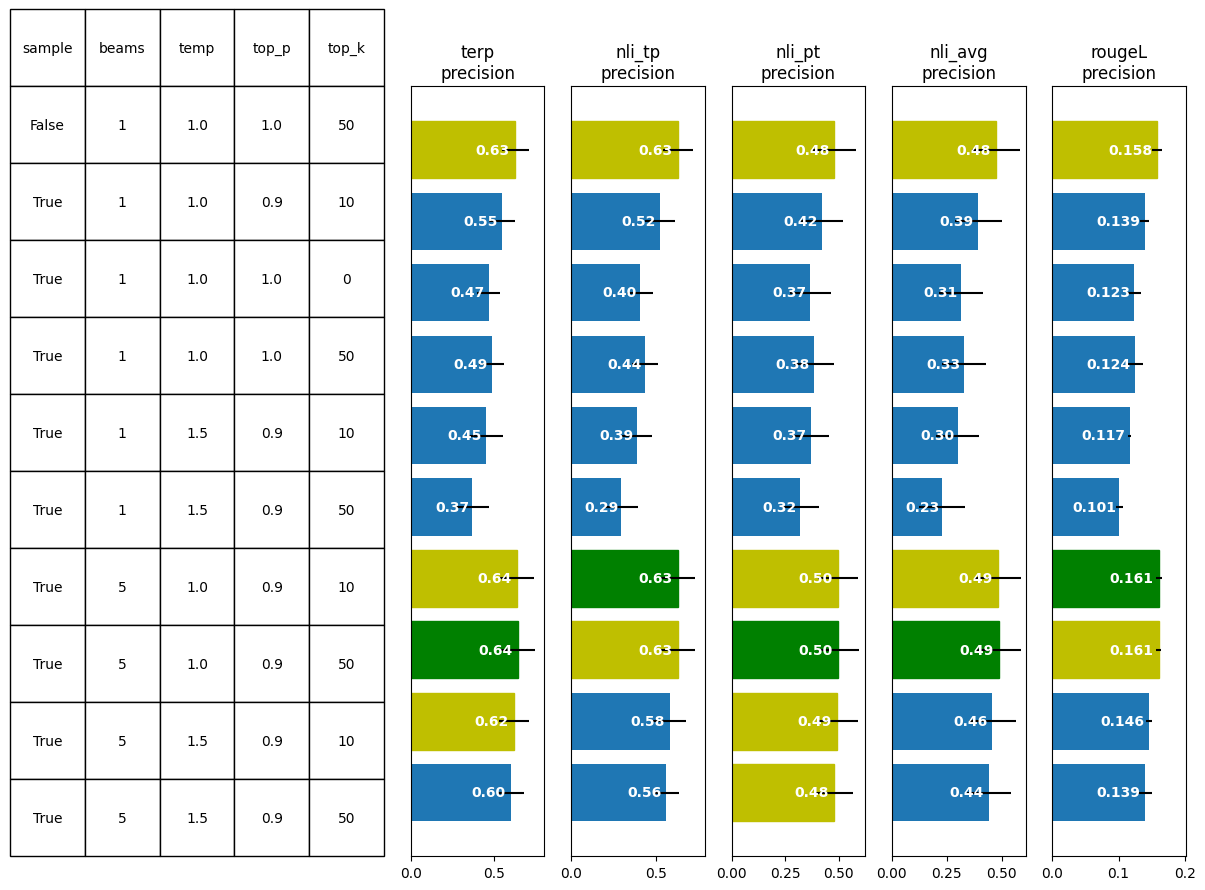

In [23]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='precision']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

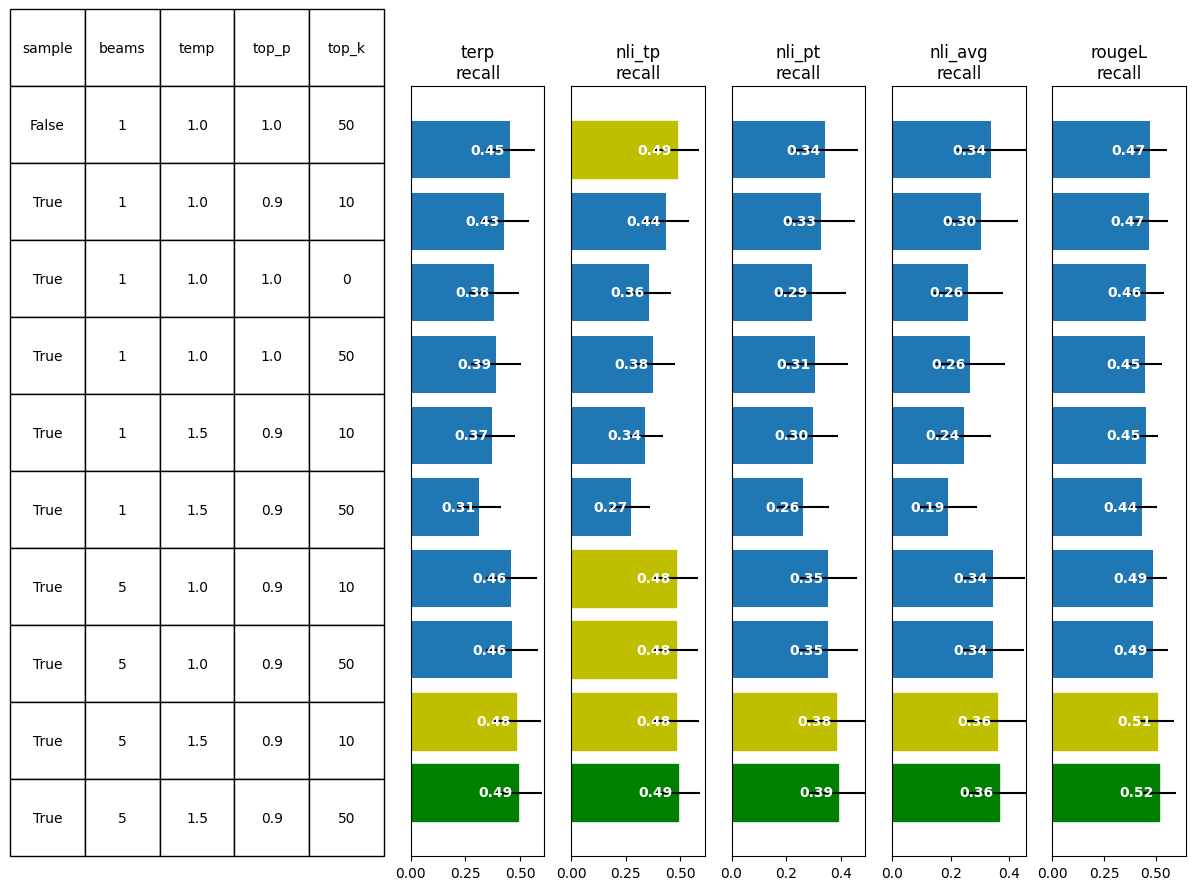

In [24]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='recall']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

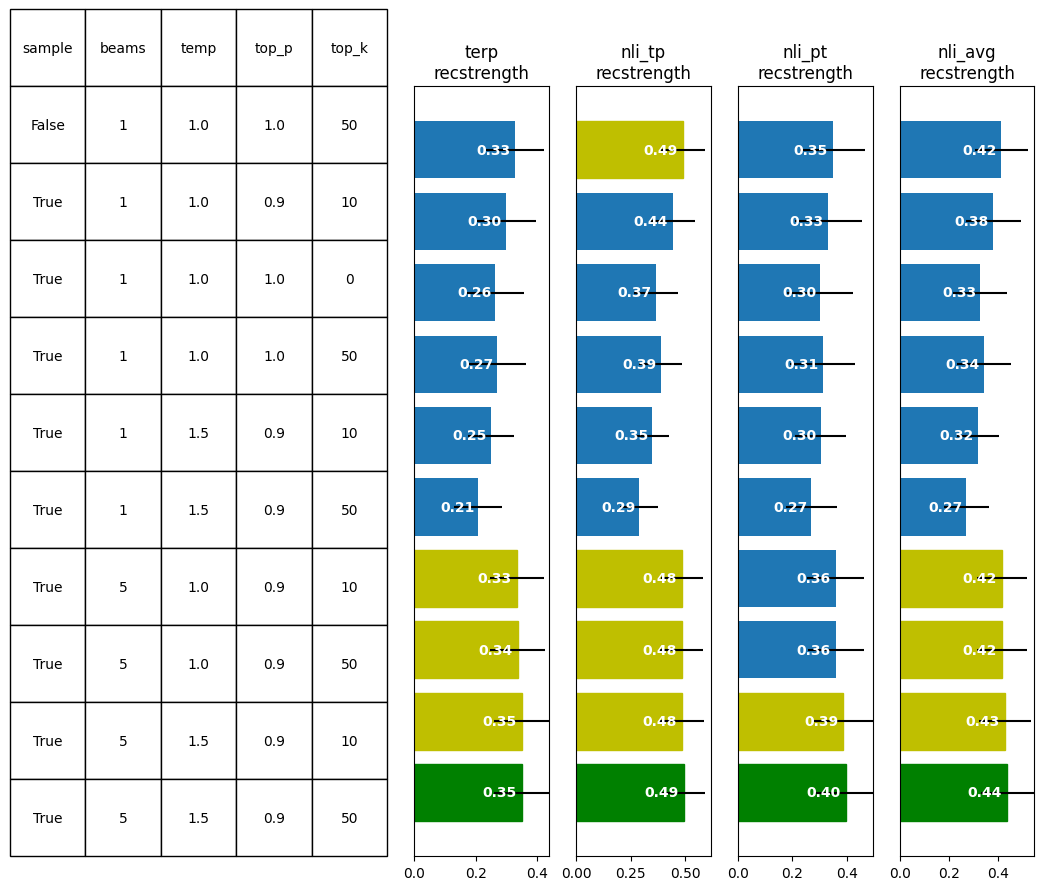

In [25]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='recstrength']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

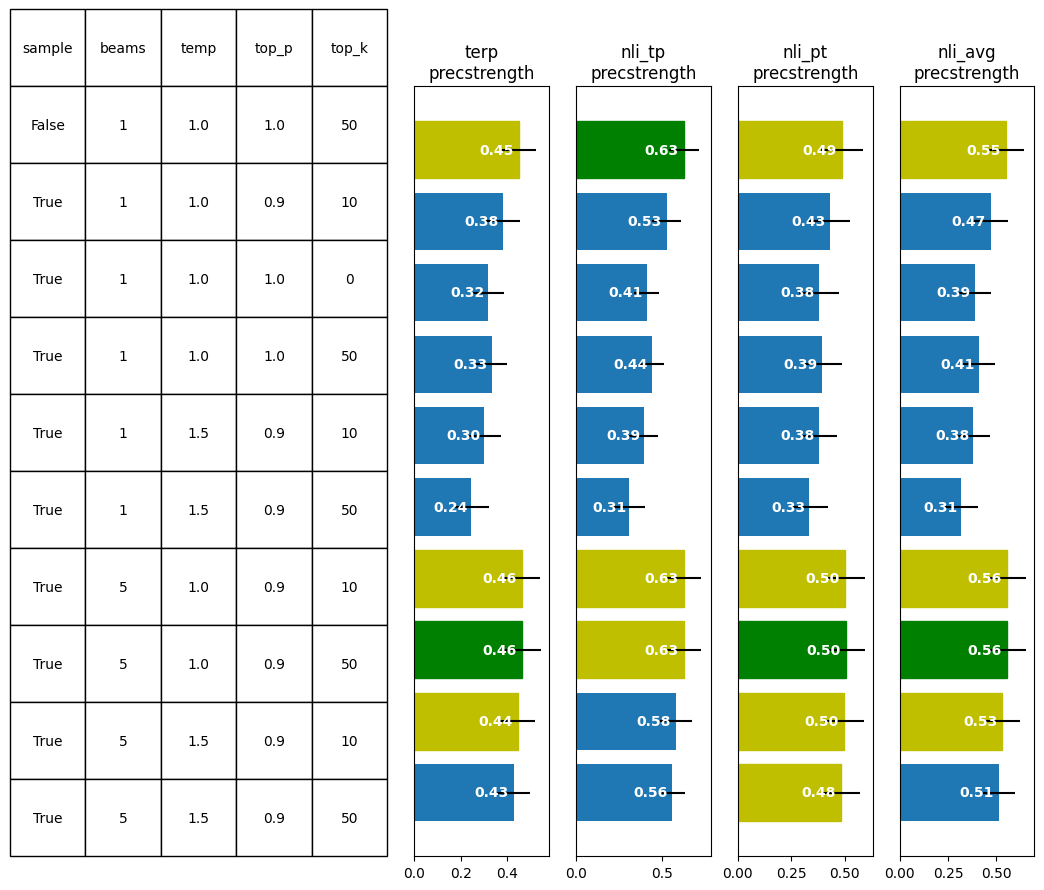

In [26]:
# Define metrics to show
eval_metrics = [(m, s) for m in metrics for s in submetrics[m] if s=='precstrength']
plot_configeval(result_df, eval_metrics)
# plot_configeval_bysession(result_df, eval_metrics)
# plot_sessioneval_byconfig(result_df, eval_metrics)

## Review eval_results

In [27]:
# Load the MSC_Summaries dataset

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
sessions = [1, 2, 3, 4]
subset = 'test'
MSC_Summaries.set(speaker_prefixes=['<other>', '<self>'])
msc_turns = {session: MSC_Summaries(basedir=basedir, session=session, subset=subset) for session in sessions}

In [28]:
print(eval_results_df.columns)
print(len(eval_results_df))

Index(['convai_id', 'pred_sentences', 'target_sentences', 'num_combinations',
       'terp', 'nli', 'nli_tp', 'nli_pt', 'nli_avg', 'numwords_factor',
       'numfacts_factor', 'rougeL', 'trial_name', 'configfile', 'seed',
       'checkpoint_dir', 'output_dir', 'log_interval', 'loglevel', 'logdir',
       'load', 'save', 'device', 'use_wandb', 'action', 'model', 'task',
       'experiment_name', 'epochs', 'learning_rate', 'valid_interval',
       'patience', 'batch_size', 'skip_eval', 'metrics', 'print_max',
       'temperature', 'top_p', 'top_k', 'do_sample', 'num_beams', 'num_turns',
       'lm_loss_factor', 'nofact_weight', 'clf_loss', 'decoder_max',
       'bart_base', 'datadir', 'basedir', 'train_samples', 'valid_samples',
       'test_samples', 'java_home', 'terpdir', 'tmpdir', 'nli_model',
       'speaker_prefixes', 'nofact_token', 'add_tokens', 'len_context',
       'session', 'new_agent', 'load_other', 'include_persona_other',
       'include_history_other', 'input_order_other'

In [29]:
eval_results_df[['session', 'numwords_factor']].groupby(['session']).count()

,numwords_factor
session,
1,5010
2,5010
3,5010
4,5010


In [30]:
# Add item results as columns in DataFrame
for metric in metrics:
    if metric not in ['numwords', 'numfacts']:
        for submetric in submetrics[metric]:
            if submetric not in ['scores']:
                # print(eval_results_df.iloc[0][metric].keys())
                if metric == 'rougeL':
                    eval_results_df[f"{metric}_{submetric}"] = eval_results_df[metric].apply(lambda row: row[f"{metric}_{submetric}"])
                else:
                    eval_results_df[f"{metric}_{submetric}"] = eval_results_df[metric].apply(lambda row: row[submetric.replace('recstrength', 'rec_strength')])

In [31]:
# Show of selection of summaries: nli_metric, target and prediction

selection = (eval_results_df['do_sample'] == True) & (eval_results_df['session'] == 3)
cols = ['pred_sentences', 'target_sentences']
metric = 'nli_pt'
submetric = 'precision'
metric_key = f"{metric}_{submetric}"

sample = eval_results_df[selection][cols + [metric_key]].sort_values(by=metric_key, ascending=True).head(25).values
for s in sample:
    print(s[2], s[0], s[1])

0.0 ['i have never bow hunting', 'i want to learn to hunt'] ['i live in oregon', "i've like hunting", 'i love medium rare steak', "i've stuffed a deer head before", 'i have experience with a shotgun']
0.0 ['i do not take care of pets', 'i have a 7 day a week job', 'i have pets', 'i have a few hours of work in the evening'] ['i own several farm animals', 'i have very limited time during the day for myself']
0.0 ['my dog wylie is ill', 'i have a son', 'my son is a bit lethargic and dragging himself around', 'i have a neighbor who has two pugs'] ["i have an appointment at the vet's office today for my dog, wylie", 'i take my dog to the ice cream stand and get him a treat', 'i like to go to the ice cream stand', 'i like pugs', 'i like rescued pets', 'i have adopted a dog']
0.0 ['i like safaris, animals, and exotic animal traveling'] ["i am interested in trying authentic jollof rice while i'm in africa", "i am looking forwarded to going on safari's while i'm in africa"]
0.0 ['i am a fan of 

In [32]:
# Test to see how many summaries are empty

def get_elem(x):
    return x[0]

selection = (eval_results_df['target_sentences'].apply(get_elem) == ' ')
cols = ['session', 'convai_id', 'pred_sentences', 'target_sentences']

eval_results_df[selection][cols]


,session,convai_id,pred_sentences,target_sentences
15,4,test_27,[ ],[ ]
457,4,test_914,[i like beaches],[ ]
41,3,test_70,[ ],[ ]
202,3,test_409,[i would prefer not to have a giraffe tooth],[ ]
260,3,test_536,[i have had a gym membership],[ ]
...,...,...,...,...
399,3,test_819,[i don't think your fiance is a conundrum],[ ]
403,3,test_823,[ ],[ ]
115,2,test_201,"[i am interested in microploxing, my husband d...",[ ]
296,2,test_626,[my cats are in captivity],[ ]


In [33]:
# Show one example

selection = eval_results_df['session'] == 3
print(eval_results_df.iloc[0].values)

['test_0'
 list(['i am looking for a new gym', 'i am looking forward to getting into shape', 'i prefer to workout alone', 'i like programming', 'i work', 'i work 8-5'])
 list(['i am joining a gym near me', 'i run', 'i am looking forward to getting in shape', 'i prefer to work out alone', 'i work as a programmer', 'i am tired of sitting in front of a computer all day', 'i work from 8 to 5'])
 42
 {'scores': [[0.7040180563926697, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.9077003002166748, 0.0, 0.38827913999557495], [0.9566409587860107, 0.1945684850215912, 1.0, 0.946806788444519, 1.0, 1.0], [1.0, 0.9076386094093323, 0.4972473680973053, 1.0, 0.9512909650802612, 1.0], [1.0, 1.0, 1.0, 1.0, 0.856161892414093, 0.9339286684989929], [0.9836938381195068, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.9582338333129883, 1.0, 1.0, 0.9512909650802612, 0.4972473680973053]], 'f1': 0.7692307706415297, 'precision': 0.8333333134651184, 'recall': 0.7142857313156128, 'prec_strength': 0.5513644814491272, 'rec_strength'

### Inspect individual examples

In [34]:
### ***THESIS*** Figure 4.11; sample in thesis has convai_id `test_2' with summary for session 4.

# Print the predicted persona summaries, with NLI_avg F1-score and TERp F1 score, for various generation configs

# Select an id to print
selection = eval_results_df['convai_id'] == 'test_2'

# Define relevant selection from eval_results
selected_metrics = ['nli_avg', 'terp', 'rougeL']
results_df = eval_results_df[selection][['session', 'gen_config', 'pred_sentences', 'target_sentences'] + selected_metrics]


# Print the predicted summaries, for all sessions
for s in [1, 2, 3, 4]:
    sub_selection = results_df['session'] == s
    target = results_df[sub_selection].iloc[0]['target_sentences']
    rows = results_df[sub_selection][['gen_config', 'pred_sentences'] + selected_metrics].sort_values(by=['gen_config']).values

    print(f"Session {s}")
    print(f"{'Target':>20}: {'. '.join(target)}")
    print(f"{' ' * 20}  NLI_avg   TERp RougeL   Prediction")

    for config, pred, nli_avg, terp, rougeL in rows:
        if config in gen_config_cat.categories:
            # print(rougeL)
            print(f"{config:>20}:    {nli_avg['f1']:.2f}   {terp['f1']:.2f}   {rougeL['rougeL_fmeasure']:.2f}   {'. '.join(pred)}")

Session 1
              Target: i drove 1000 miles to see a band. roxy music is my favorite band. i'm from farmer stock. i like chet baker. i just moved to charlotte, nc
                      NLI_avg   TERp RougeL   Prediction
              Greedy:    0.44   0.44   0.46   i drive 1,000 miles. my favorite band is roxy. i am from meself. i just moved to charlotte, nc
   Unbiased sampling:    0.50   0.57   0.52   i know my favorite band. my favorite band is roxy. i have just moved to charlotte, nc
         Narrow beam:    0.48   0.40   0.39   i have a fave band. my favorite band is roxy. i have 2 older brothers. i am from meself. i just moved to charlotte, nc
    Flat-Narrow beam:    0.36   0.18   0.34   i love my fave band. i drive 1,000 miles. i have 2 older brothers. i like roxy music. i am from meself. i just moved to charlotte, nc
     Flat-Broad beam:    0.44   0.36   0.32   my favorite band is my fave band. i drove 1,000 miles. my favorite band is oxygen. i have 2 older brothers. i

### Heatmaps

Number of dialog_id's:  1


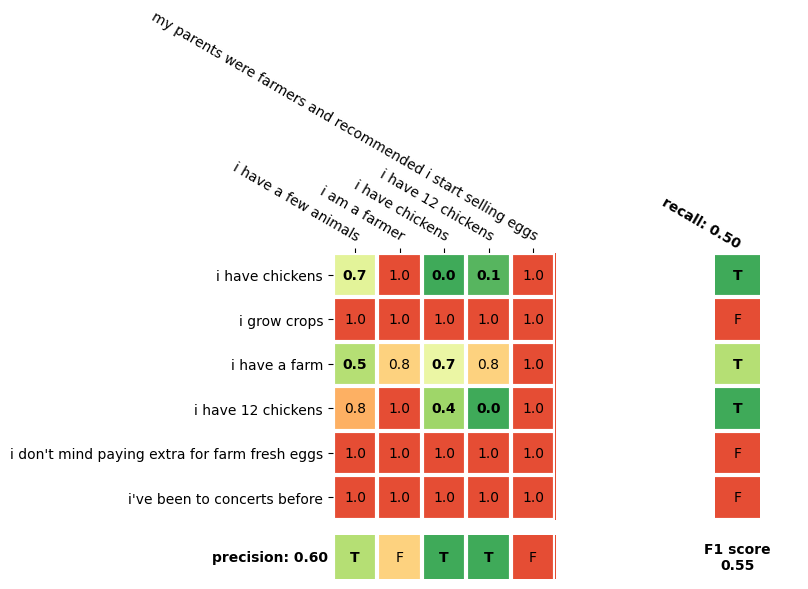

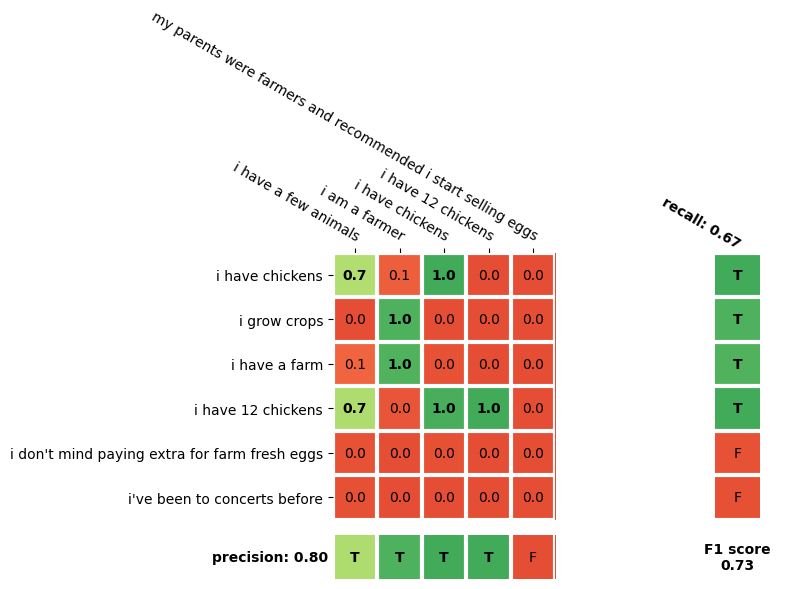

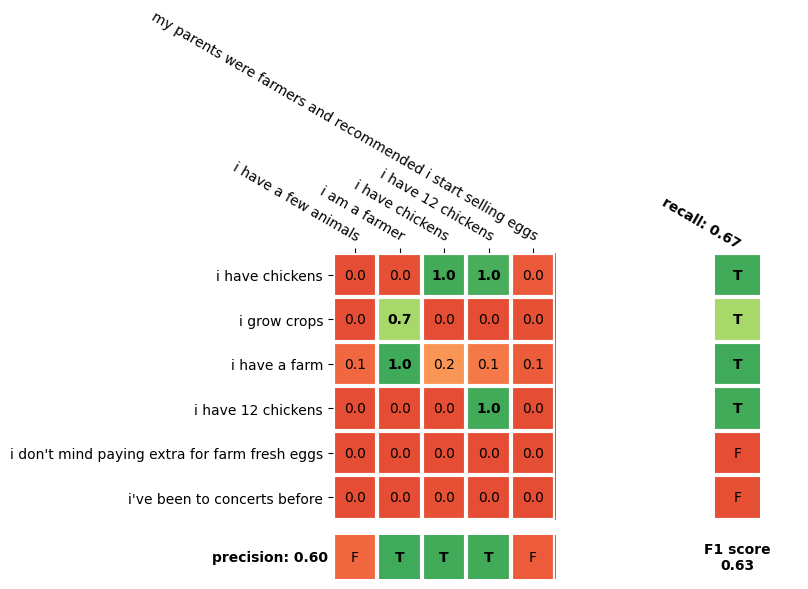

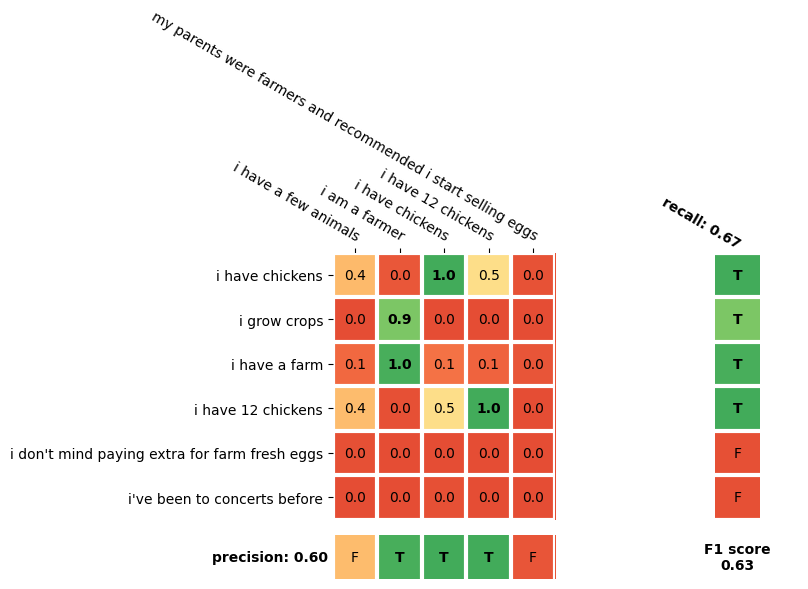

In [35]:
### ***THESIS*** Figure 4.11; sample in thesis has convai_id `test_2' and generation strategy 'Flat-Broad beam' with summary for session 4.

# Make heatmaps for a selection of summaries

# Select which heatmaps to print
convai_id = 'test_2'
session = 4
gen_config = 'Flat-Broad beam'

# Define subselection of dataframe
selected_metrics = ['nli_tp', 'nli_pt', 'nli_avg', 'terp']
selection = (eval_results_df['convai_id'] == convai_id) & (eval_results_df['session'] == session) & (eval_results_df['gen_config'] == gen_config)
results_dict = eval_results_df[selection][selected_metrics + ['target_sentences', 'pred_sentences', 'convai_id']].to_dict('index')
print("Number of dialog_id's: ", len(results_dict.keys()))

# Plot and save the heatmaps
savedir = "../docs/"
subset = 'test'      # Because all eval_results are from test dataset, is used in title of the saved file
plot_heatmaps(results_dict, session, subset, savedir)


### Length

(0.0, 100.0)


(0.0, 100.0)

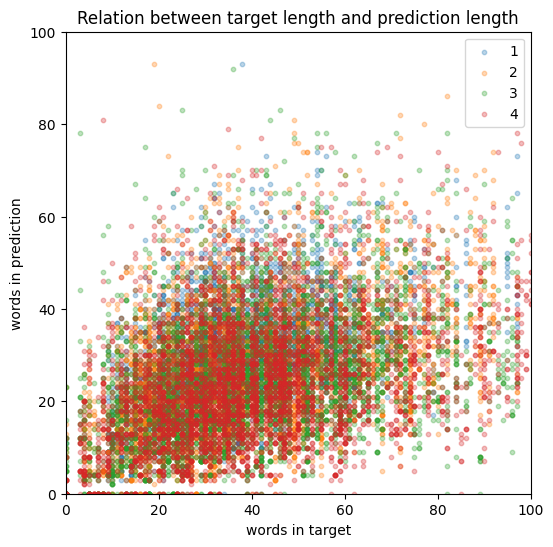

In [36]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for s in [1, 2, 3, 4]:
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    ax.scatter(x, y, s=10, alpha=0.3, label=s)
ax.set_title("Relation between target length and prediction length")
ax.legend()
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('words in target')
ax.set_ylabel('words in prediction')
ax.set_xlim(0, 100)
print(ax.get_xlim())
ax.set_ylim(ax.get_xlim())


(0.0, 80.0)

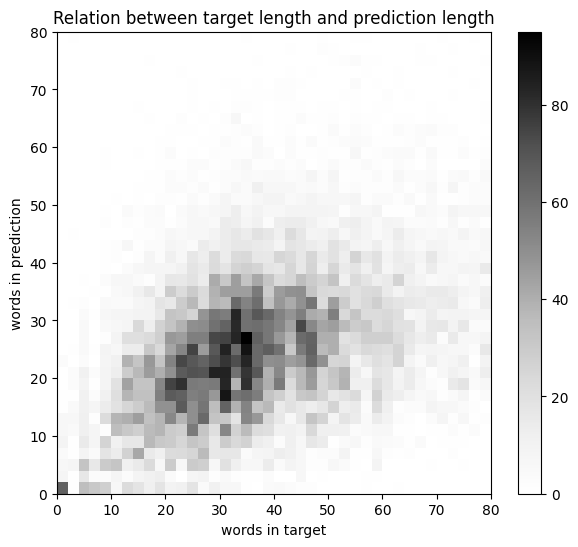

In [37]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
bin_edges = np.linspace(0,80, 41)

x = eval_results_df['target_sentences'].apply(lambda x: get_length(x))
y = eval_results_df['pred_sentences'].apply(lambda x: get_length(x))
ax_hist = ax.hist2d(x, y, bins=(bin_edges, bin_edges), cmap='Greys')
fig.colorbar(ax_hist[3])
ax.set_xticks(np.linspace(0,100,11))
ax.set_xlim(0, 80)
ax.set_ylim(ax.get_xlim())
ax.set_title("Relation between target length and prediction length")
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('words in target')
ax.set_ylabel('words in prediction')
ax.set_xlim(0, 80)
ax.set_ylim(ax.get_xlim())


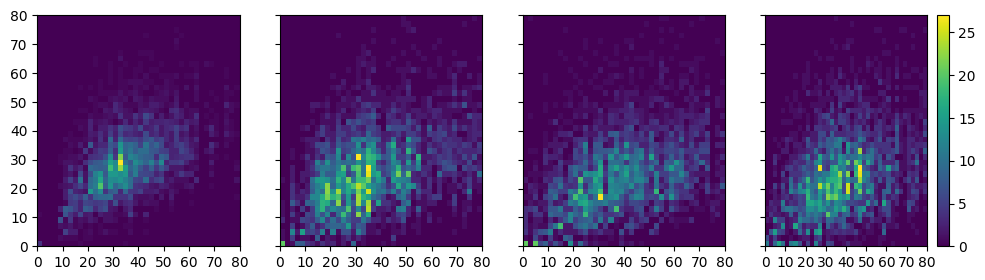

In [38]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
bin_edges = np.linspace(0,80, 41)
for s, ax in zip([1, 2, 3, 4], axs):
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    h = ax.hist2d(x, y, bins=(bin_edges, bin_edges))
    ax.set_xticks(np.linspace(0,100,11))
    ax.set_xlim(0, 80)
    ax.set_ylim(ax.get_xlim())
# ax.set_title("Relation between target length and prediction length")
# ax.legend()
# # ax.grid(which='major', axis='y', linestyle='--')
# # ax.grid(which='major', axis='x', linestyle='--')
# ax.set_xlabel('words in target')
# ax.set_ylabel('words in prediction')

fig.colorbar(h[3], ax=ax)

(0.0, 23.05)


(0.0, 23.05)

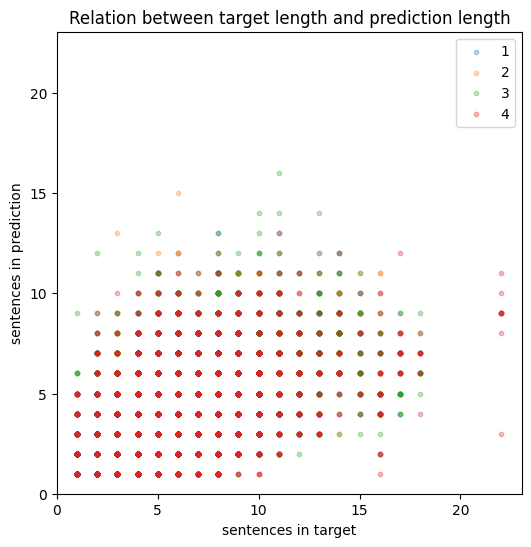

In [39]:
def get_length(sentence_list):
    l = len(sentence_list)
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for s in [1, 2, 3, 4]:
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    ax.scatter(x, y, s=10, alpha=0.3, label=s)
ax.set_title("Relation between target length and prediction length")
ax.legend()
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('sentences in target')
ax.set_ylabel('sentences in prediction')
ax.set_xlim(0)
print(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
